### Примеры работы с clickhouse и sql на основе данных об аренде жилья

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandahouse as ph
from ast import literal_eval

In [65]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
connection_default = {'host': 'http://clickhouse...',
                      'database':'default',
                      'user':'', 
                      'password':''
                     }

In [7]:
q = '''
    SELECT 
        count(*) 
    FROM 
        ldn_listings 
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count()
0,85207


In [14]:
# запрос для подсчета уникальных хозяев, которые регистрировались через гугл

q7 = '''
    select 
        count(DISTINCT host_id)
    from ldn_listings
    WHERE   like(host_verifications, '%google%')
        and experiences_offered != 'none' 
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_7 = ph.read_clickhouse(query=q7, connection=connection_default)
q_7

,uniqExact(host_id)
0,34


In [8]:
# отбираем предложенные "впечатления" и группируем по районам

q8 = '''
    select 
        neighbourhood_cleansed,
        experiences_offered,
        count(*) as experiences_count           
    from
        ldn_listings
    where experiences_offered != 'none'    
    group by neighbourhood_cleansed, experiences_offered
    order by experiences_count desc
    limit 100
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_8 = ph.read_clickhouse(query=q8, connection=connection_default)
q_8

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Merton,romantic,2
96,Redbridge,social,2
97,City of London,family,1
98,Barking and Dagenham,business,1


In [53]:
# преобразуем таблицу в более удобный вид
q_8_mod = q_8.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
q_8_mod

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,1.0,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0
Enfield,3.0,NaN,NaN,2.0


In [ ]:
cmap=sns.cubehelix_palette(as_cmap=True)

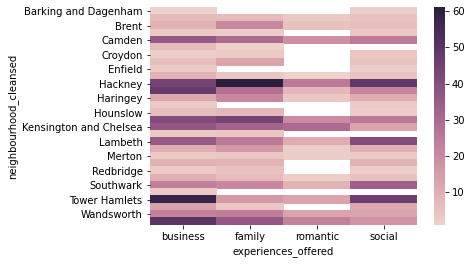

In [54]:
# визуализируем посредством тепловой карты
sns.heatmap(q_8_mod, cmap=sns.cubehelix_palette(as_cmap=True))

In [58]:
# отбираем виды жилья, для которых доступны "впечатления", удаляем из цены лишние символы

q9 = '''
    select 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr        
    from
        ldn_listings
    where experiences_offered != 'none'   
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_9 = ph.read_clickhouse(query=q9, connection=connection_default)
q_9

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


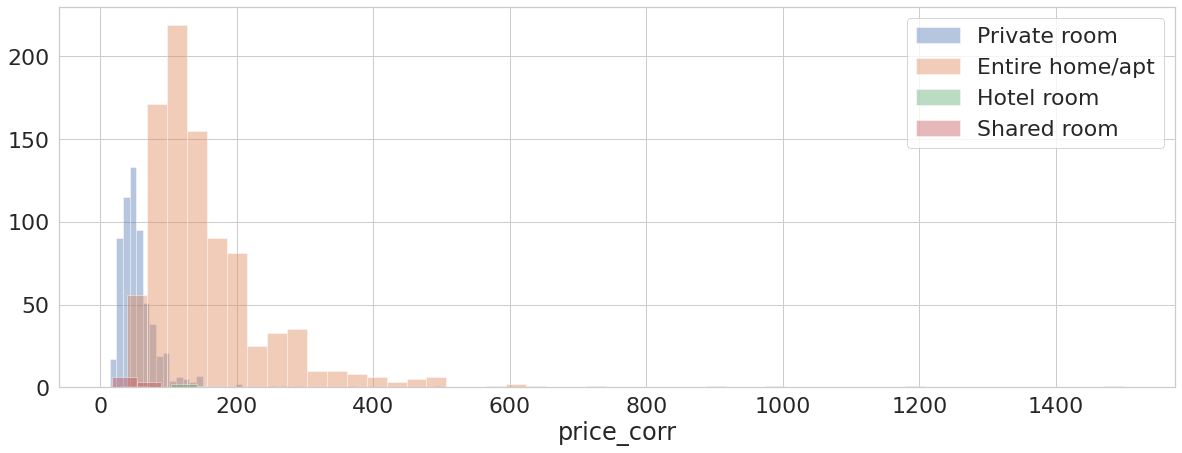

In [72]:
# визуализируем на общем графике гистограммы цен
for r_type in q_9.room_type.unique():
    sns.distplot(q_9[q_9.room_type == r_type].price_corr, kde=False, label=r_type)
plt.legend()

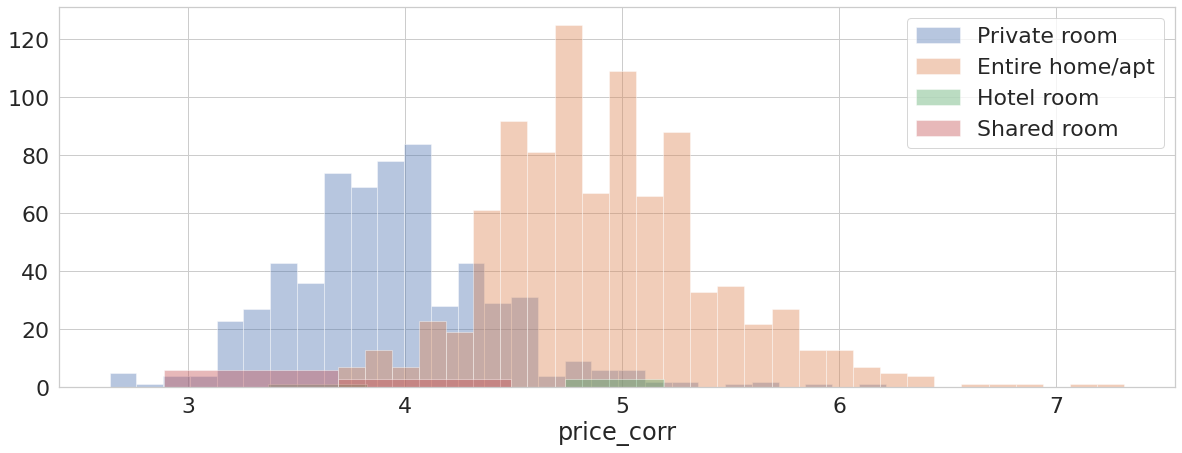

In [71]:
# первый график из-за малого количества данных по отдельным категориям плохо читается
# применим логарифмирование для данных
for r_type in q_9.room_type.unique():
    sns.distplot(np.log(q_9[q_9.room_type == r_type].price_corr), kde=False, label=r_type)
plt.legend()